In [12]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [13]:
def euclidean_distance(x1, x2):
    euclidean = np.sqrt(np.sum((x1-x2)**2))
    return euclidean

def find_points(kp1, kp2, matches, numb_of_matches=10,dst=1):

  # находим самое точное совпадение
  pt1 = kp1[matches[0].queryIdx].pt
  group_of_points=[pt1]
  pattern_points = [kp2[matches[0].trainIdx].pt]

  # пробегаемся по остальным, последний numb_of_matches совпадениям и "кластеризуем" по евклидовому расстоянию
  for mat in matches[1:numb_of_matches]:
    pt = kp1[mat.queryIdx].pt
    dist = euclidean_distance(np.array(pt1), np.array(pt))

    if dist < dst:
      group_of_points.append(pt)
      pattern_points.append(kp2[mat.trainIdx].pt)
  return group_of_points, pattern_points

def get_bbox(group_of_points, pattern_points, w2, h2, original_w, original_h):
  # находим какую-то центральную точку для для каждого из двух изображений
  middle_point1 = np.mean(group_of_points, axis=0)
  middle_point2 = np.mean(pattern_points, axis=0)

  # находим координаты ограничивающего прямоугольника - верхний левый угол и правый нижний
  top_left = max(0, int(middle_point1[0] - middle_point2[0])), max(0, int(middle_point1[1] - middle_point2[1]))
  bottom_right = min(original_w, int(w2 - middle_point2[0] + middle_point1[0])), min(original_h, int(h2 - middle_point2[1] + middle_point1[1]))
  return top_left, bottom_right


In [14]:
from ast import pattern
# поиск по ключевым точкам, получить peak coord

def matchTemplate(path_img, path_pattern):

    # Load the input images
    input_image = cv2.imread(path_img, cv2.IMREAD_GRAYSCALE)
    h,w = input_image.shape
    pattern_template = cv2.imread(path_pattern, cv2.IMREAD_GRAYSCALE)

    # M = cv2.getRotationMatrix2D(
    #     (int(pattern_template.shape[1]/2), int(pattern_template.shape[0]/2)),
    #     angle=-60,
    #     scale=1)
    # pattern_template = cv2.warpAffine(pattern_template, M, dsize=(pattern_template.shape[1], pattern_template.shape[0]))

    # Инициализация ORB-detector
    orb = cv2.ORB_create()
    # Поиск ключевых точек
    kp1, des1 = orb.detectAndCompute(input_image,None)
    kp2, des2 = orb.detectAndCompute(pattern_template,None)
    # BFMatcher
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(des1,des2)
    # сортировка соответствий
    matches = sorted(matches, key = lambda x:x.distance)

    # поиск точек, принадлежащих нужному объекту
    group_of_points, pattern_points = find_points(kp1, kp2, matches, numb_of_matches=5, dst=2)
    # определение ограничивающего прямоугольника
    h2, w2 = pattern_template.shape
    top_left, bottom_right = get_bbox(group_of_points, pattern_points, w2, h2, w, h)

    highlight_start = top_left
    highlight_end = bottom_right
    return highlight_start, highlight_end, input_image, pattern_template


In [15]:
def show(input_image, pattern_template, highlight_start, highlight_end,row):
    cv2.rectangle(input_image,(row["x1"],row["y1"]), (row["x2"],row["y2"]),(255,0,0), 2)
    cv2.rectangle(input_image, highlight_start, highlight_end, 255, 2)
    # Visualize the pattern template and resulting image
    fig_instance, axes_arr = plt.subplots(1, 2, figsize=(10, 5))

    # Show the pattern template
    axes_arr[0].imshow(pattern_template, cmap='gray')
    axes_arr[0].set_title(f'Pattern Template id: {row["id"]}')

    # Show the input image with the highlighted match
    axes_arr[1].imshow(input_image, cmap='gray')
    axes_arr[1].set_title(f'Pattern Highlighted id: {row["id"]}')

    plt.show()

In [16]:
def iou(row, highlight_start, highlight_end):
  bboxA = row["x1"], row["y1"], row["x2"], row["y2"]
  bboxB = highlight_start[0], highlight_start[1], highlight_end[0], highlight_end[1]
  ix1 = max(bboxA[0], bboxB[0])
  iy1 = max(bboxA[1], bboxB[1])
  ix2 = min(bboxA[2], bboxB[2])
  iy2 = min(bboxA[3], bboxB[3])
  intersection = max(0, (ix2-ix1))*max(0,(iy2-iy1))

  bboxA_area = (bboxA[2] - bboxA[0]) * (bboxA[3] - bboxA[1])
  bboxB_area = (bboxB[2] - bboxB[0]) * (bboxB[3] - bboxB[1])
  return float(intersection/(bboxA_area + bboxB_area - intersection))

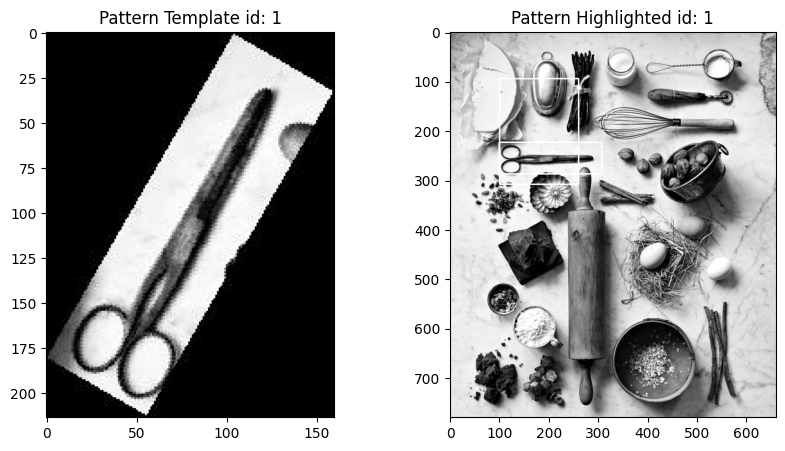

0.274442538593482


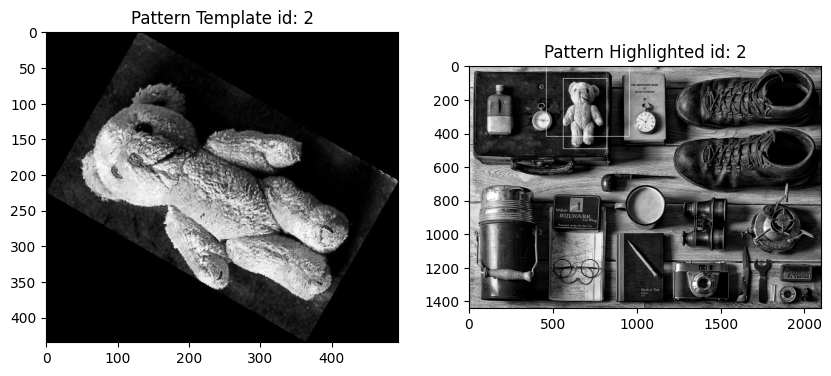

0.3973738769868694


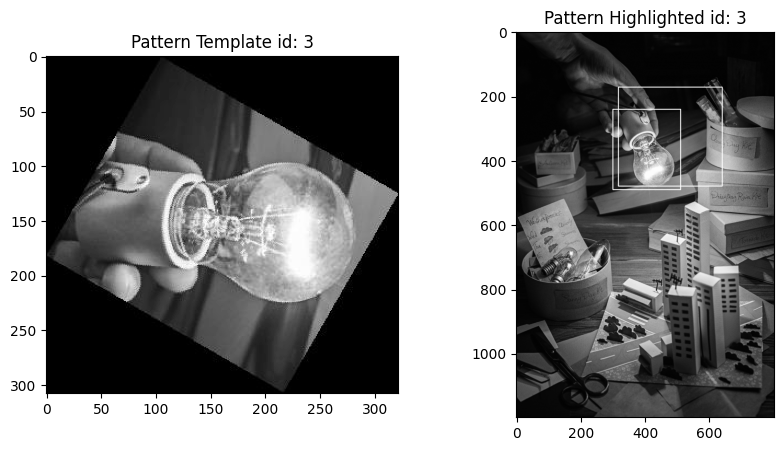

0.43701977280694276


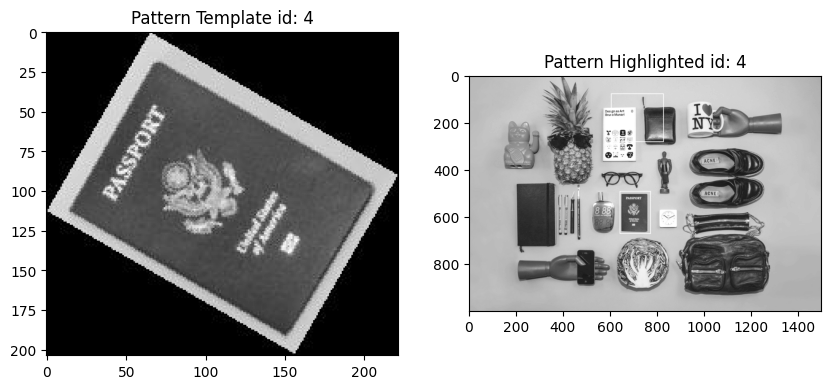

0.0


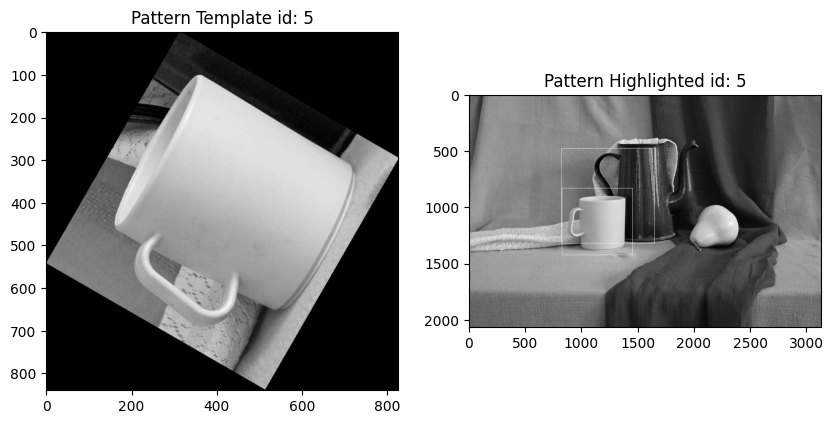

0.40251718176835183


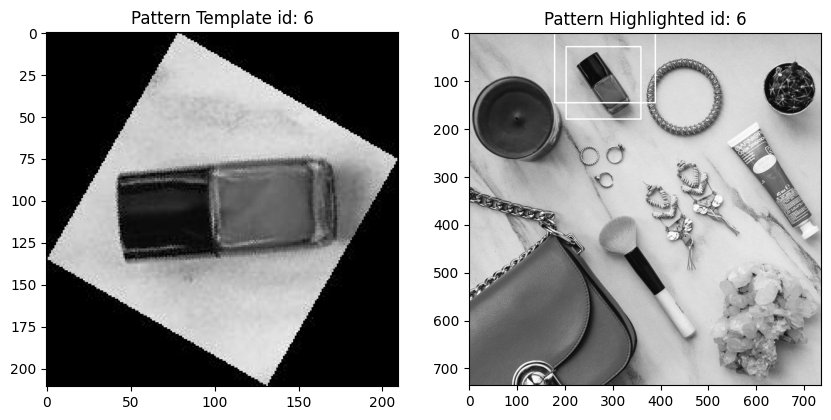

0.5045612871122906


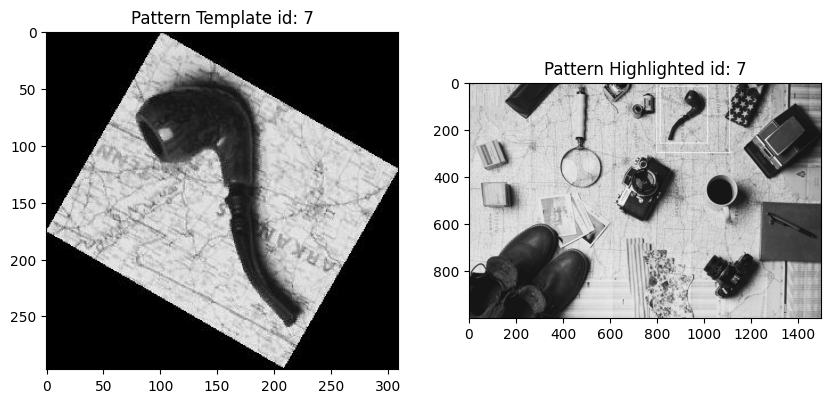

0.5287498642337352


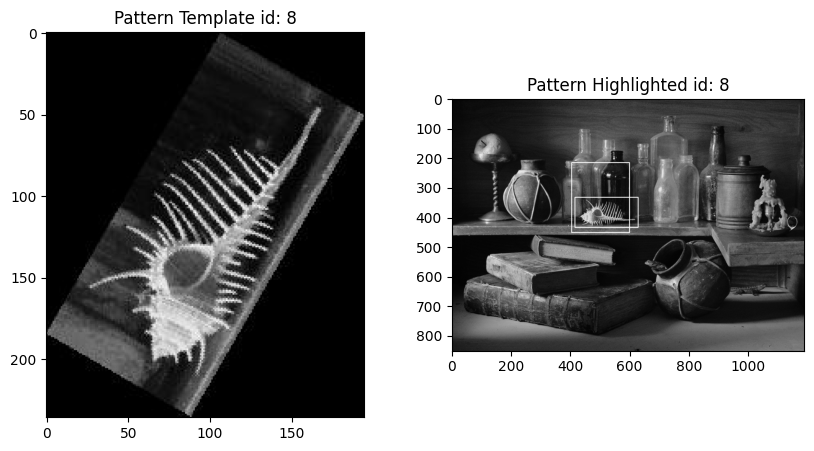

0.38319245375474703


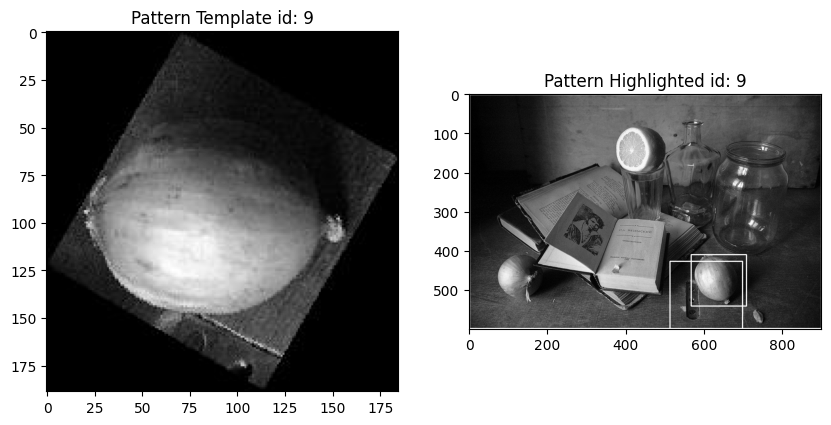

0.4201789432221034


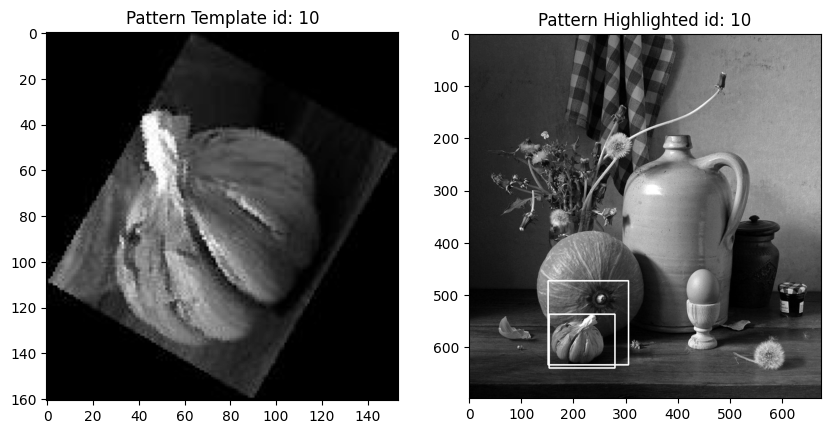

0.47835616438356166


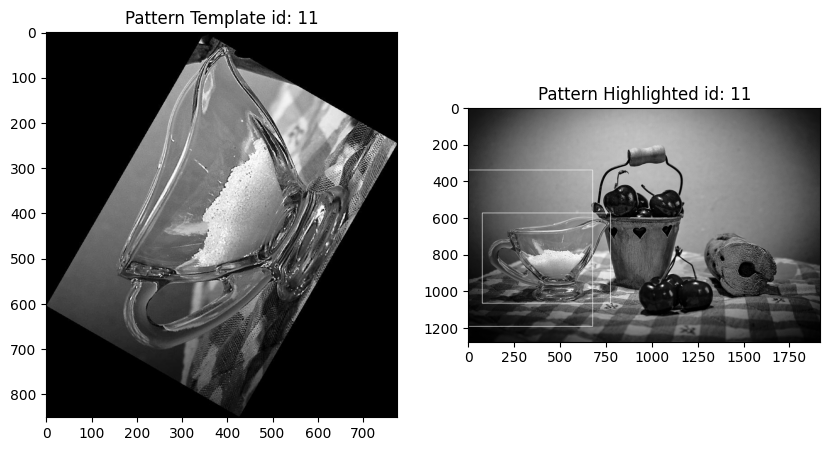

0.47244418472474603


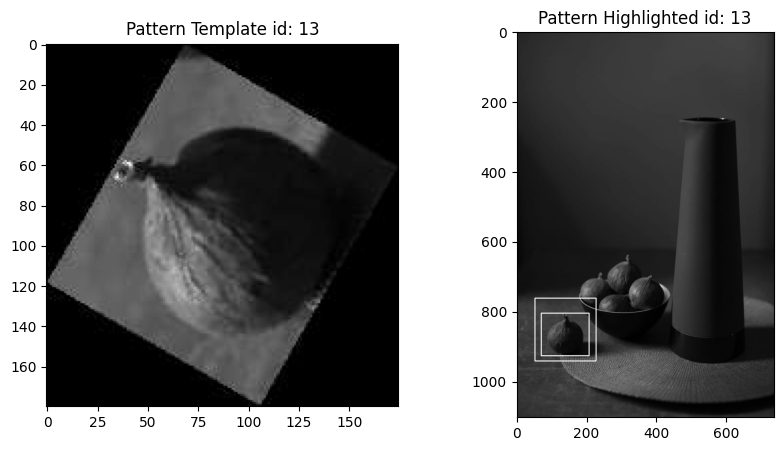

0.5306031746031746


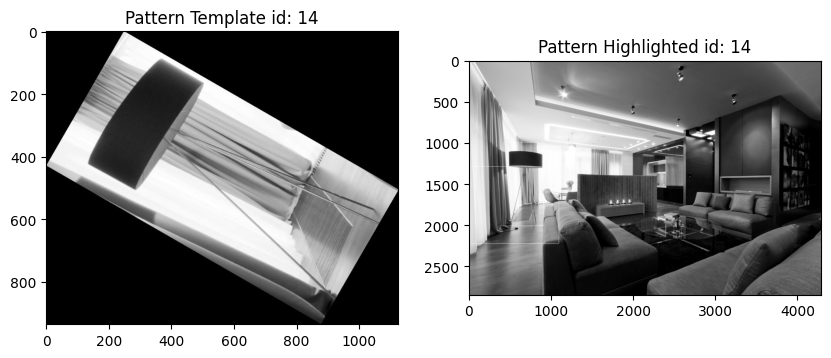

0.3065854628753275


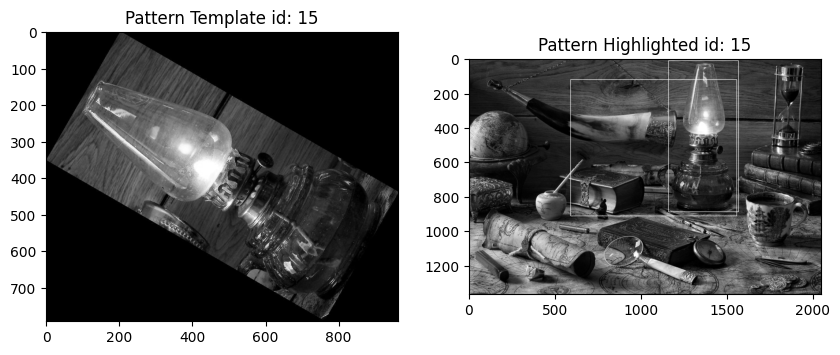

0.372784459469398


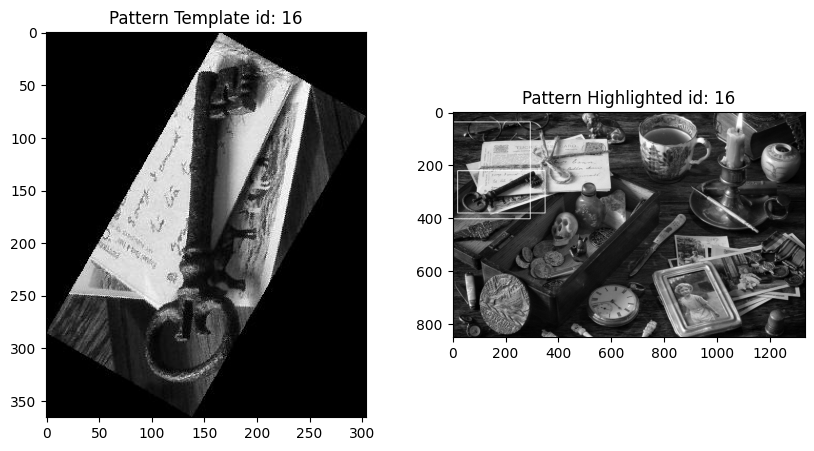

0.3796788665061577


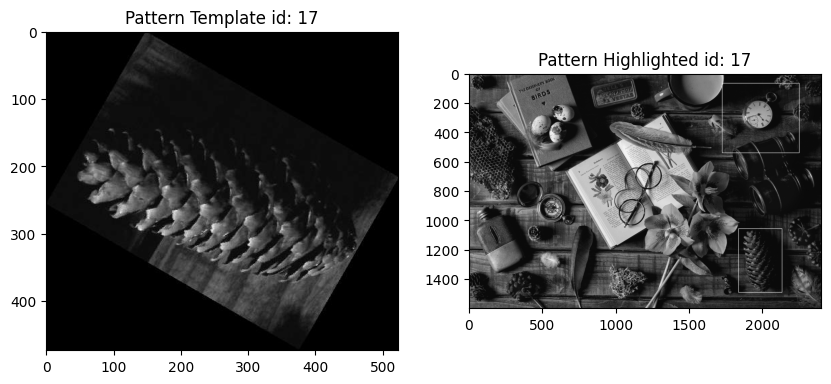

0.0


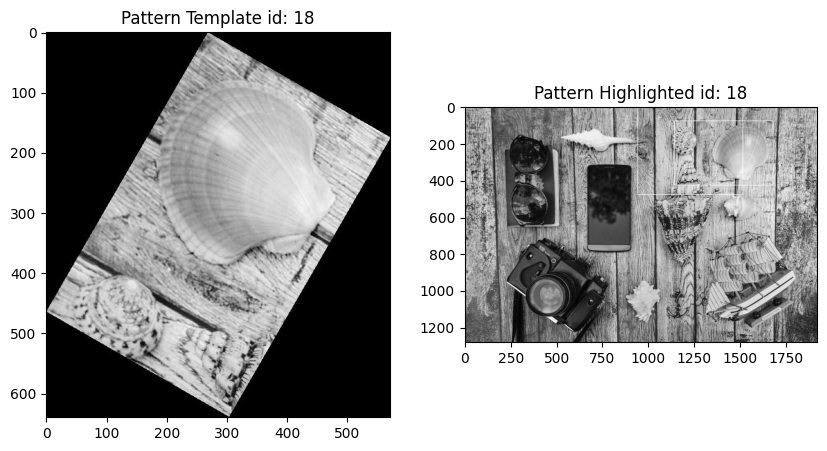

0.39493799898080517


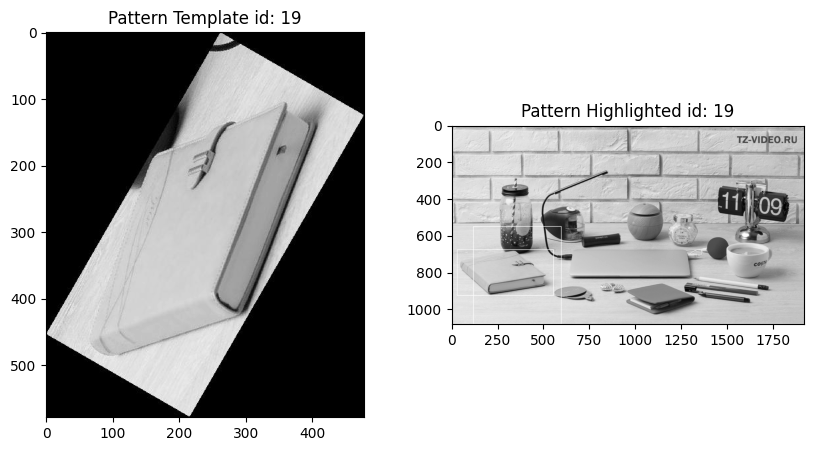

0.39441675264848214


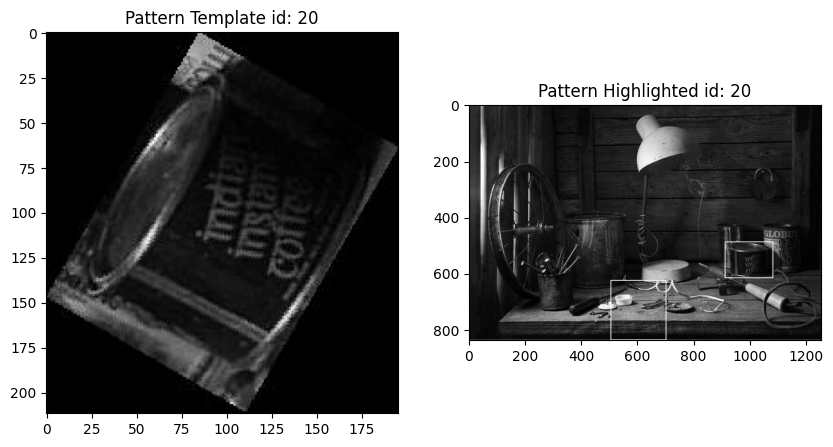

0.0


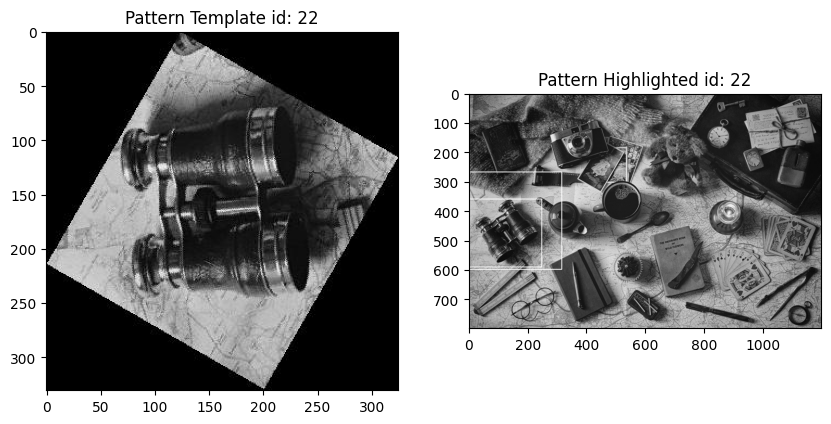

0.5472306143001007


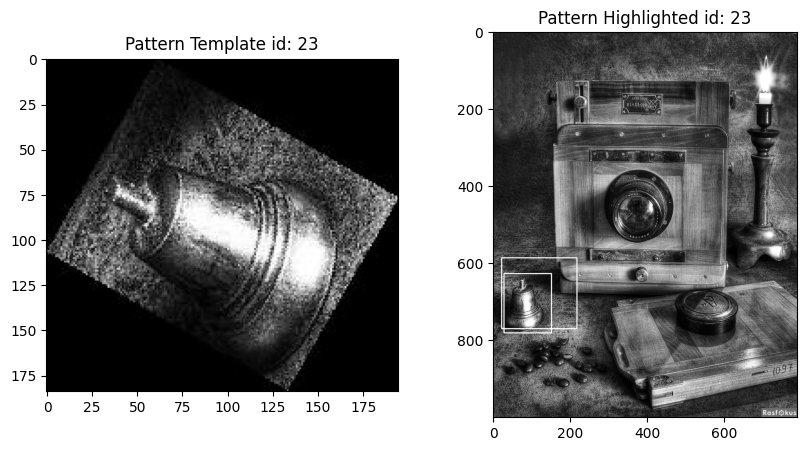

0.47240351301265004


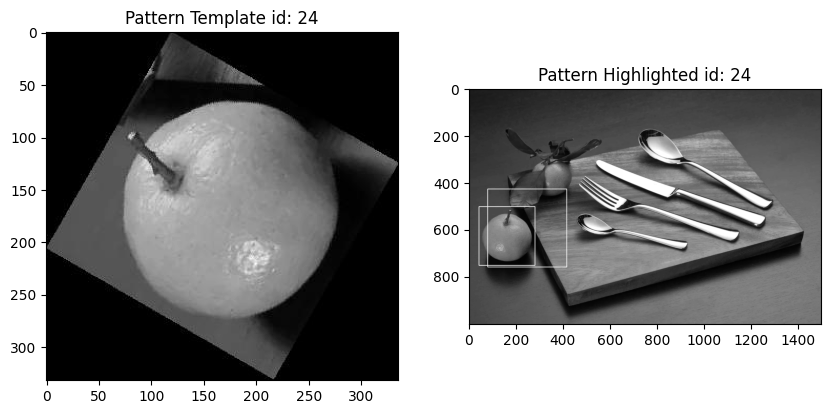

0.41596993427261136


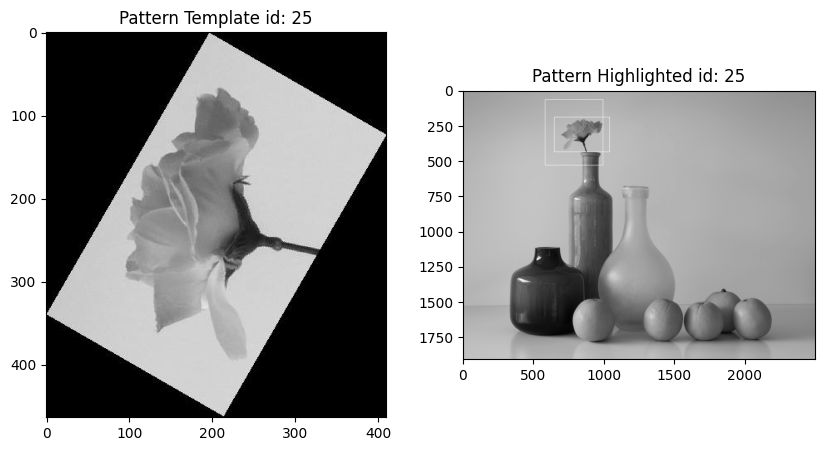

0.4205607476635514


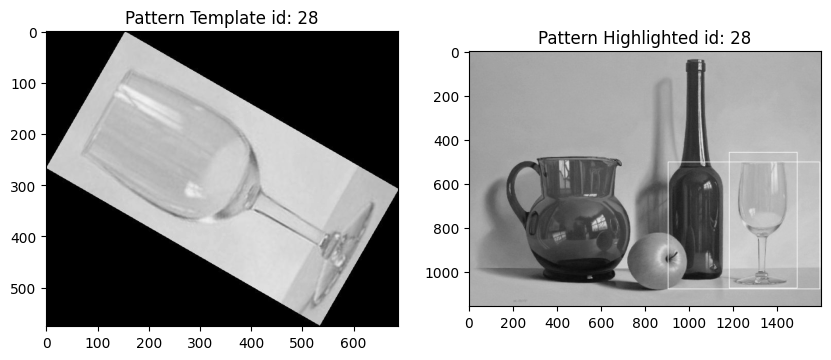

0.4298653132929924


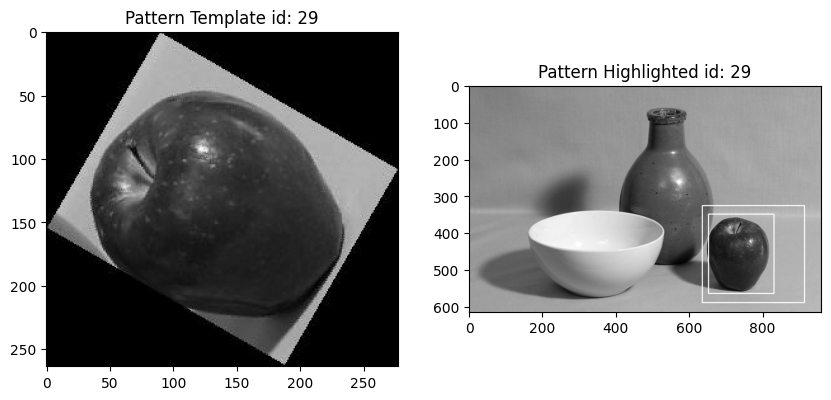

0.5238718116415958


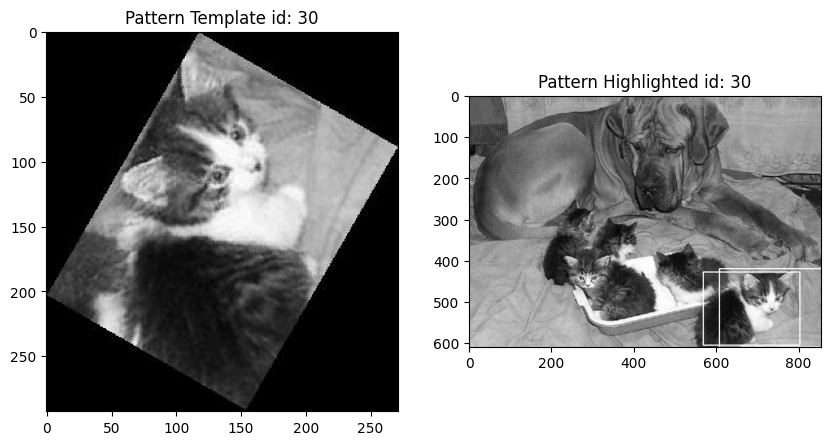

0.6366554147529191


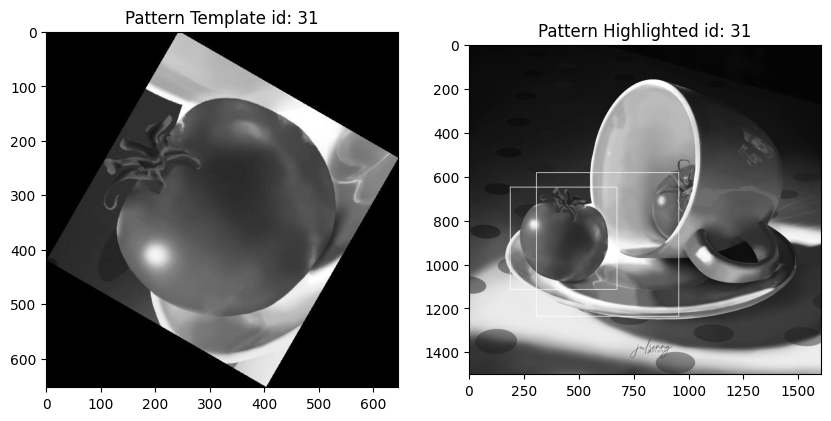

0.3561756790128624


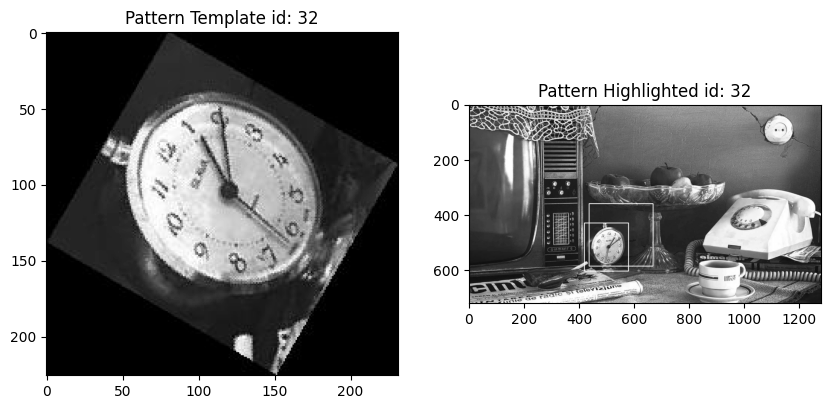

0.3848595680077289


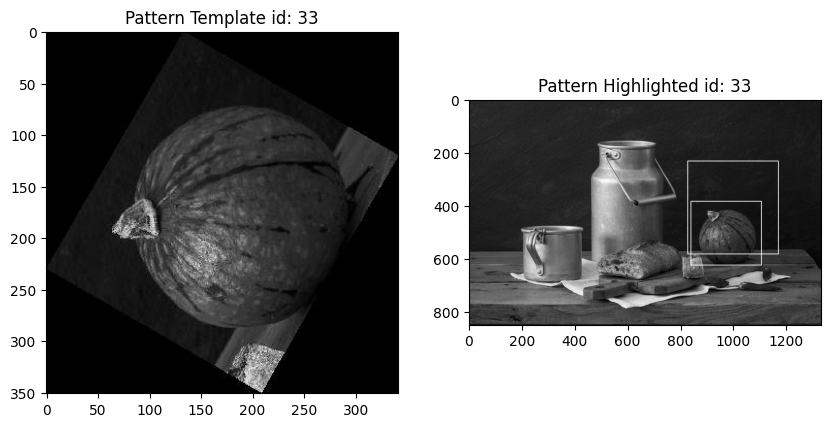

0.40341731827396465


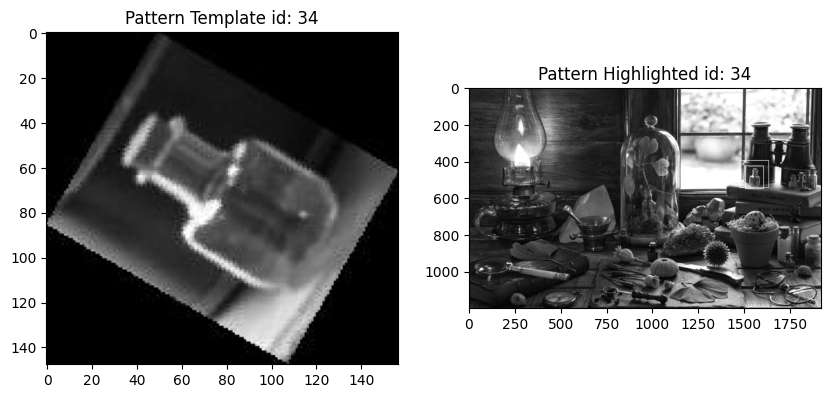

0.4902224087284935


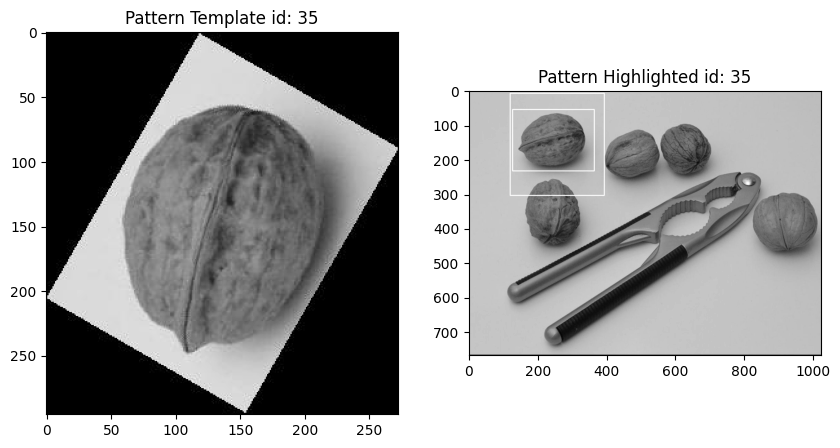

0.522052272052272


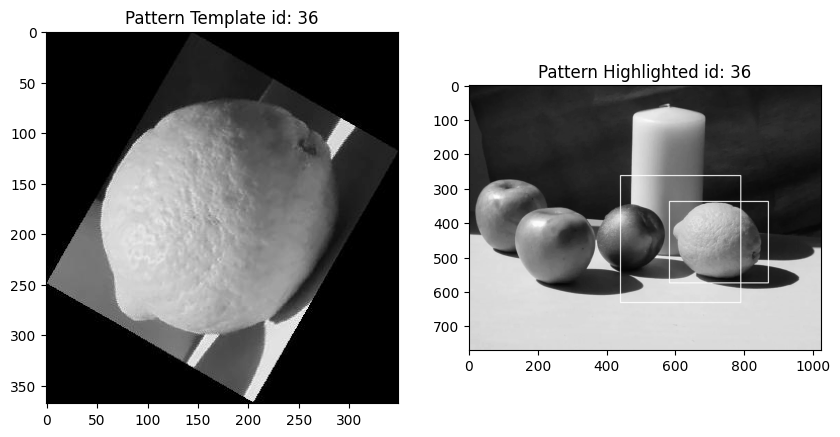

0.33162267839687193


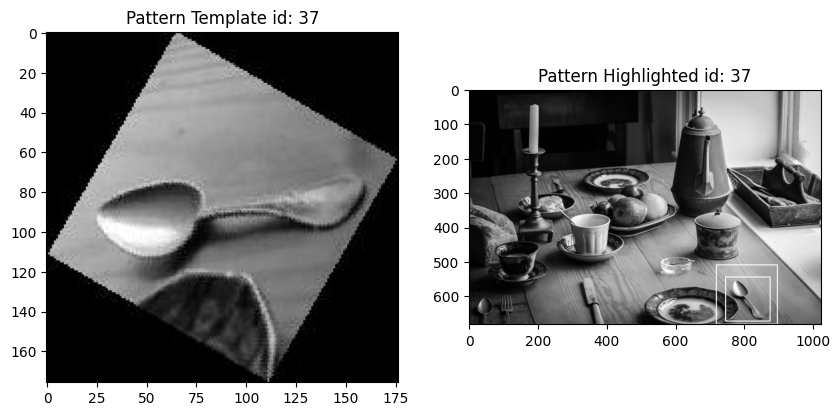

0.5423728813559322


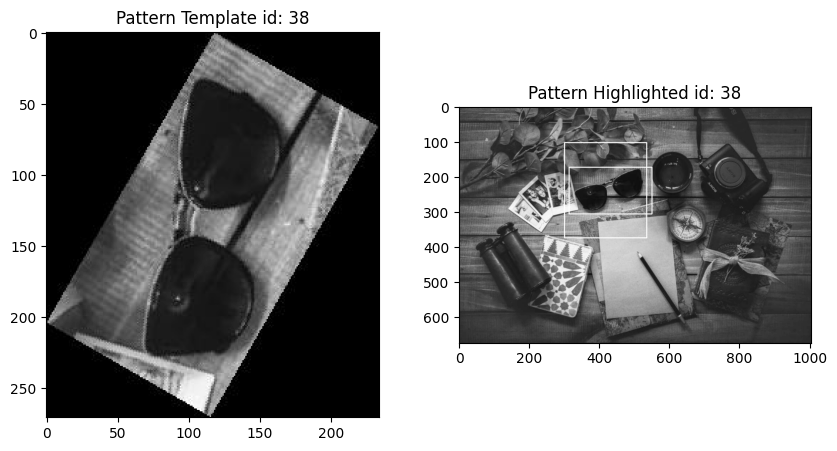

0.4493724105245456


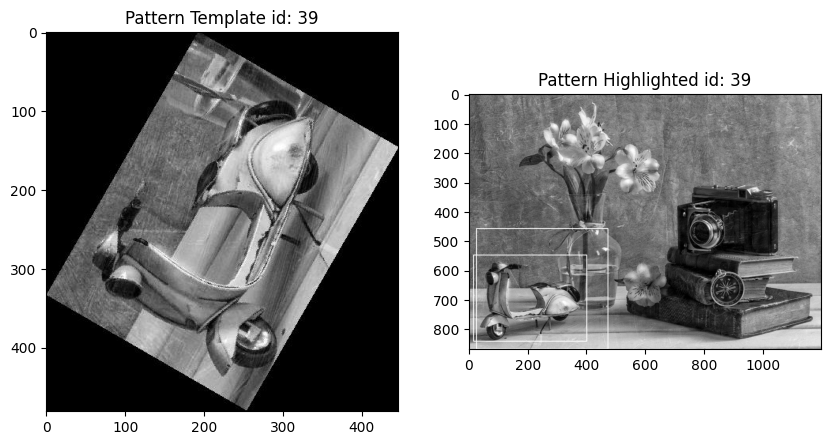

0.5900912996777659


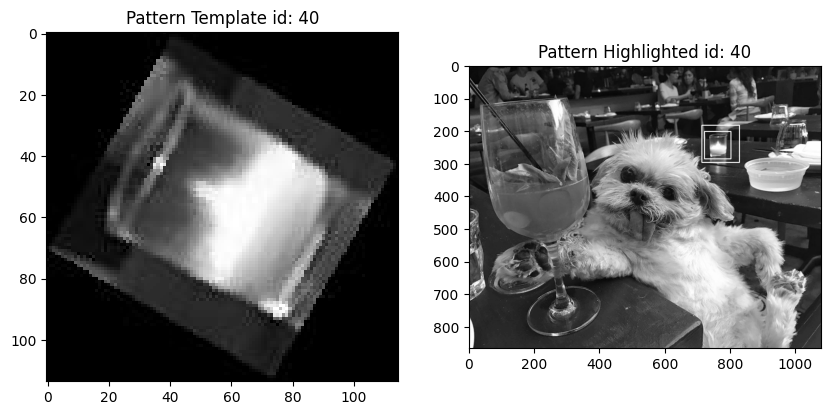

0.5189931350114416
iou_mean 0.40871055507356874


In [17]:
# загрузка изображений, перебор
import statistics
import pandas as pd
dataset = pd.read_csv('dataset/annotation.csv', delimiter=';')
dataset.head()
iou_array=[]
for i in range(0,36):
    row = dataset.iloc[i]
    highlight_start, highlight_end, input_image, pattern_template =matchTemplate(f"dataset/{row['id']}.jpg", f"dataset/pattern/cropped_img_{row['id']}.jpg")
    iou_metric = iou(row,highlight_start,highlight_end)
    show(input_image, pattern_template,highlight_start,highlight_end, row )
    print(iou_metric)
    iou_array.append(iou_metric)

iou_mean = statistics.mean(iou_array)
print("iou_mean",iou_mean)